In [1]:
import pandas as pd
from glob import glob
from evaluate.report import Report, PrecisionReport, RecallReport
from collections import defaultdict, namedtuple
import re
import intervaltree
import seaborn as sns
sns.set()
import json
import pickle

def dump_object_to_json(dictionary, filename):
    json_str = json.dumps(dictionary)
    with open(f"{filename}.json","w") as fout:
        fout.write(json_str)

def dump_object(obj, filename):
    with open(f"{filename}.pickle","w") as fout:
        pickle.dump(obj, fout)

In [2]:
##################################################################################################################
# configs
# local
reports_tsv_glob_path = "/home/leandro/git/pandora_paper_roc/external_scripts/pandora_FN_exploration/data/hps/nobackup/iqbal/leandro/pdrv2/paper_pandora2020_analyses/out_20_way/pandora_paper_roc/analysis_output_pandora_paper_tag1/recall/reports/*/100x/pandora_nanopore_withdenovo/coverage_filter_0/strand_bias_filter_0.0/gaps_filter_1.0/gt_conf_percentile_0/*.tsv"
samples = ['063_STEC', 'CFT073', 'Escherichia_coli_MINF_1D', 'Escherichia_coli_MINF_9A', 'Escherichia_coli_MSB1_4E']  # TODO: remove
gene_localisation_dir="/home/leandro/git/pandora_paper_roc/external_scripts/pandora_FN_exploration/data/hps/nobackup/iqbal/leandro/pdrv2/paper_pandora2020_analyses/out_20_way/pandora_gene_distance/gene_distance_vcf_completed_with_prg/genes_from_truth_or_ref/pandora_vcf_ref_nanopore_100x_with_prg"
pandora_multisample_vcf_ref="data/pandora_multisample.vcf_ref.fa"

# cluster
# reports_tsv_glob_path = "/hps/nobackup/iqbal/leandro/pdrv2/paper_pandora2020_analyses/out_20_way/pandora_paper_roc/analysis_output_pandora_paper_tag1/recall/reports/*/100x/pandora_nanopore_withdenovo/coverage_filter_0/strand_bias_filter_0.0/gaps_filter_1.0/gt_conf_percentile_0/*.tsv"
# samples = ['063_STEC', 'Escherichia_coli_MINF_1D', 'Escherichia_coli_MINF_9A', 'Escherichia_coli_MSB1_4E', 'Escherichia_coli_MSB1_7A', 'Escherichia_coli_MSB1_8G', 'H131800734', 'CFT073', 'Escherichia_coli_MINF_7C', 'Escherichia_coli_MSB1_1A', 'Escherichia_coli_MSB1_4I', 'Escherichia_coli_MSB1_7C', 'Escherichia_coli_MSB1_9D', 'ST38', 'Escherichia_coli_MINF_1A', 'Escherichia_coli_MINF_8D', 'Escherichia_coli_MSB1_3B', 'Escherichia_coli_MSB1_6C', 'Escherichia_coli_MSB1_8B', 'Escherichia_coli_MSB2_1A']
# gene_localisation_dir="/hps/nobackup/iqbal/leandro/pdrv2/paper_pandora2020_analyses/out_20_way/pandora_gene_distance/gene_distance_vcf_completed_with_prg/genes_from_truth_or_ref/pandora_vcf_ref_nanopore_100x_with_prg"
# pandora_multisample_vcf_ref="/hps/nobackup/iqbal/leandro/pdrv2/paper_pandora2020_analyses/out_20_way/pandora_workflow/pandora_output_pandora_paper_tag1/nanopore/100x/random/compare_withdenovo/pandora_multisample.vcf_ref.fa"
##################################################################################################################

In [3]:
# get the report
def keep_report(filepath):
    for sample in samples:
        if sample in filepath:
            return True
    return False

reports_filepaths = glob(reports_tsv_glob_path)
reports_filepaths = [filepath for filepath in reports_filepaths if keep_report(filepath)]
recall_report = RecallReport.from_files(reports_filepaths,
                                        concatenate_dfs_one_by_one_keeping_only_best_mappings=True)
recall_report.report

,sample,query_probe_header,ref_probe_header,classification,GT_CONF,PVID,NB_ALL,ALL_ID,NB_DIFF_ALL_SEQ,ALL_SEQ_ID,NB_OF_SAMPLES,good_eval
0,063_STEC,>CHROM=0;SAMPLE=063_STEC;POS=1000001;REF_LEN=1...,>CHROM=GC00002374;GT_CONF=0;,primary_correct,0.0,125154,18,0,2,1,18,True
1,063_STEC,>CHROM=0;SAMPLE=063_STEC;POS=100001;REF_LEN=1;...,>CHROM=GC00000546_2;GT_CONF=0;,primary_correct,0.0,207802,16,0,2,1,16,True
2,063_STEC,>CHROM=0;SAMPLE=063_STEC;POS=1000031;REF_LEN=1...,>CHROM=GC00002374;GT_CONF=0;,primary_correct,0.0,163011,11,0,2,0,11,True
3,063_STEC,>CHROM=0;SAMPLE=063_STEC;POS=100003;REF_LEN=1;...,>CHROM=GC00000546_2;GT_CONF=0;,primary_correct,0.0,220083,8,0,2,0,8,True
4,063_STEC,>CHROM=0;SAMPLE=063_STEC;POS=100004;REF_LEN=1;...,>CHROM=GC00000546_2;GT_CONF=0;,primary_correct,0.0,38525,9,0,2,1,9,True
...,...,...,...,...,...,...,...,...,...,...,...,...
4607357,Escherichia_coli_MINF_8D,>CHROM=9;SAMPLE=Escherichia_coli_MINF_8D;POS=2...,>CHROM=GC00005873_2;GT_CONF=0;,partially_mapped,0.0,609822,5,0,2,0,5,False
4607358,Escherichia_coli_MINF_8D,>CHROM=9;SAMPLE=Escherichia_coli_MINF_8D;POS=5...,>CHROM=Cluster_122;GT_CONF=0;,primary_incorrect,0.0,617593,6,0,2,0,6,False
4607359,Escherichia_coli_MINF_8D,>CHROM=9;SAMPLE=Escherichia_coli_MINF_8D;POS=5...,>CHROM=Cluster_122;GT_CONF=0;,primary_incorrect,0.0,617594,4,0,2,1,4,False
4607360,Escherichia_coli_MINF_8D,>CHROM=9;SAMPLE=Escherichia_coli_MINF_8D;POS=7...,>CHROM=GC00007531;GT_CONF=0;,partially_mapped,0.0,609819,6,0,2,1,6,False


In [4]:
# get a df with the info needed for the pvs
chroms_array = []
samples_array = []
positions = []
pv_ids_array = []
for header in recall_report.report["query_probe_header"]:
    chrom, sample, pv_id, pos = re.findall("CHROM=(.+?);SAMPLE=(.+?);.*;PVID=(.+?);.*;OR_POS=(.+?);.*", header)[0]
    chroms_array.append(chrom)
    samples_array.append(sample)
    pv_ids_array.append(int(pv_id))
    positions.append(int(pos))
pvs_df = pd.DataFrame(data={"chrom": chroms_array, "sample": samples_array, "pos": positions, "pv_id": pv_ids_array})
pvs_df.to_csv("pvs_df.csv", index=False)
pvs_df

,chrom,sample,pos,pv_id
0,0,063_STEC,1000001,125154
1,0,063_STEC,100001,207802
2,0,063_STEC,1000031,163011
3,0,063_STEC,100003,220083
4,0,063_STEC,100004,38525
...,...,...,...,...
4607357,9,Escherichia_coli_MINF_8D,222,609822
4607358,9,Escherichia_coli_MINF_8D,52,617593
4607359,9,Escherichia_coli_MINF_8D,59,617594
4607360,9,Escherichia_coli_MINF_8D,7,609819


In [5]:
sample_to_chrom_to_intervaltree = defaultdict(lambda: defaultdict(lambda: intervaltree.IntervalTree()))
for sample in samples:
    filename = gene_localisation_dir+f"/{sample}.csv"
    with open(filename) as gene_localisation_fh:
        for line in gene_localisation_fh:
            status,gene_name,ref_or_truth_id,contig,start,stop,sequence,strand = line.strip().split(",")
            if status=="Mapped":
                start, stop = int(start), int(stop)
                sample_to_chrom_to_intervaltree[ref_or_truth_id][contig][start:stop] = gene_name

sample_to_chrom_to_intervaltree

defaultdict(<function __main__.<lambda>()>,
            {'063_STEC': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'0': IntervalTree([Interval(3, 1404, 'GC00000491_1'), Interval(1700, 1898, 'GC00003082'), Interval(2010, 2148, 'GC00001920'), Interval(2151, 2200, 'Cluster_12991_not_in_VCF_ref_only_in_PRG'), Interval(2200, 2524, 'GC00002322'), Interval(2490, 2745, 'GC00002627'), Interval(2561, 2750, 'Cluster_4592'), Interval(2750, 4394, 'GC00001921'), Interval(4397, 4502, 'Cluster_9156'), Interval(4502, 5864, 'GC00001724'), Interval(5867, 6172, 'Cluster_2653'), Interval(6108, 6180, 'GC00002323'), Interval(6403, 7816, 'GC00002763'), Interval(7633, 7909, 'Cluster_3176'), Interval(7819, 7954, 'Cluster_7792'), Interval(7909, 9154, 'GC00000131_2'), Interval(8164, 8260, 'Cluster_9796_not_in_VCF_ref_only_in_PRG'), Interval(9157, 9289, 'Cluster_3743'), Interval(9289, 10462, 'GC00001922'), Interval(10439, 11396, 'GC00001089_2'), Interval(11399, 11555, 'Clu

In [6]:
def find_genes(chrom, sample, pos):
    genes = set()
    for gene in sample_to_chrom_to_intervaltree[sample][chrom][pos]:
        genes.add(gene.data)
    return genes

pv_to_genes = defaultdict(set)
for chrom, sample, pos, pv_id in zip(pvs_df["chrom"], pvs_df["sample"], pvs_df["pos"], pvs_df["pv_id"]):
    pv_to_genes[pv_id].update(find_genes(chrom, sample, pos))

for pv in pv_to_genes:
    pv_to_genes[pv] = list(pv_to_genes[pv])

dump_object_to_json(pv_to_genes, "pv_to_genes")

pv_to_genes

defaultdict(set,
            {125154: ['GC00002374'],
             207802: ['GC00000546_2'],
             163011: ['GC00002374'],
             220083: ['GC00000546_2'],
             38525: ['GC00000546_2'],
             163012: ['GC00001468'],
             50873: ['GC00001468'],
             50874: ['GC00001468'],
             50875: ['GC00001468'],
             125156: ['GC00001468'],
             50876: ['GC00001468'],
             50877: ['GC00001468'],
             125157: ['GC00001468'],
             6915: ['GC00001468'],
             38528: ['GC00000546_2'],
             158141: ['GC00001922'],
             38529: ['GC00000546_2'],
             125158: ['GC00001468'],
             241939: ['GC00001468'],
             50878: ['GC00001468'],
             222048: ['GC00001468'],
             232941: ['GC00001468'],
             163013: ['GC00001468'],
             50879: ['GC00001468'],
             163014: ['GC00001468'],
             241940: ['GC00001468'],
             125159: ['

In [7]:
variation_found_nbofsamples = recall_report.get_proportion_of_allele_seqs_found_for_each_variant_with_nb_of_samples(
    binary=True
)
variation_found_nbofsamples.rename(columns={"proportion_of_allele_seqs_found_binary": "FOUND"}, inplace=True)
variation_found_nbofsamples.reset_index(inplace=True)
variation_found_nbofsamples.to_csv("variation_found_nbofsamples.csv", index=False)
variation_found_nbofsamples

,PVID,FOUND,NB_OF_SAMPLES
0,0,0,2
1,1,1,4
2,2,1,2
3,3,1,20
4,4,1,19
...,...,...,...
546799,663010,1,4
546800,663011,1,4
546801,663012,1,4
546802,663013,0,2


In [18]:
pv_to_nb_of_genes_found_by_pandora = {}
for pv, genes in pv_to_genes.items():
    pv_to_nb_of_genes_found_by_pandora[pv] = len(list(filter(
        lambda gene: "_not_in_VCF_ref_only_in_PRG" not in gene, genes)))
    
pv_to_gene_stats_df = pd.DataFrame(data=pv_to_nb_of_genes_found_by_pandora.items(),
                                                 columns=["PVID", "NB_OF_GENES"])
pv_to_gene_stats_df["FOUND_IN_VCF_REF"] = (pv_to_gene_stats_df["NB_OF_GENES"] > 0).astype(int)

pv_to_gene_stats_df

,PVID,NB_OF_GENES,FOUND_IN_VCF_REF
0,125154,1,1
1,207802,1,1
2,163011,1,1
3,220083,1,1
4,38525,1,1
...,...,...,...
546799,609785,1,1
546800,609819,0,0
546801,609823,0,0
546802,609824,0,0


In [36]:
import numpy as np

pv_to_nb_of_genes_only_in_PRG = {}
for pv, genes in pv_to_genes.items():
    pv_to_nb_of_genes_only_in_PRG[pv] = len(list(filter(
        lambda gene: "_not_in_VCF_ref_only_in_PRG" in gene, genes)))
  
pv_to_gene_stats_df["HAS_GENES_IN_PRG_ONLY"] = (np.array(list(pv_to_nb_of_genes_only_in_PRG.values())) > 0).astype(int)

pv_to_gene_stats_df["NOT_FOUND_IN_VCF_REF_BUT_IN_PRG"] = ((pv_to_gene_stats_df["FOUND_IN_VCF_REF"]==0) & (pv_to_gene_stats_df["HAS_GENES_IN_PRG_ONLY"]==1)).astype(int)

pv_to_gene_stats_df.to_csv("pv_to_gene_stats_df.csv", index=False)

pv_to_gene_stats_df

,PVID,NB_OF_GENES,FOUND_IN_VCF_REF,HAS_GENES_IN_PRG_ONLY,NOT_FOUND_IN_VCF_REF_BUT_IN_PRG
0,125154,1,1,0,0
1,207802,1,1,0,0
2,163011,1,1,0,0
3,220083,1,1,0,0
4,38525,1,1,0,0
...,...,...,...,...,...
546799,609785,1,1,0,0
546800,609819,0,0,0,0
546801,609823,0,0,0,0
546802,609824,0,0,0,0


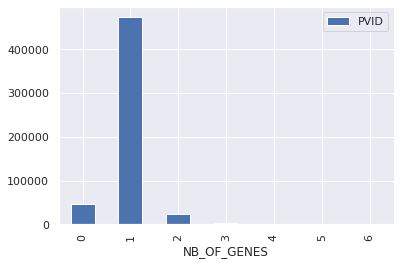

In [38]:
pv_ids_to_nb_of_genes_summary = pv_id_to_nb_of_genes_found_by_pandora_df[["PVID", "NB_OF_GENES"]].groupby("NB_OF_GENES").count()
plot = pv_ids_to_nb_of_genes_summary.plot(kind="bar")
fig = plot.get_figure()
fig.savefig("pandora_nb_of_genes_for_panvars.png")

In [43]:
variation_found_nbofsamples = variation_found_nbofsamples.merge(pv_to_gene_stats_df)
variation_found_nbofsamples
variation_found_nbofsamples["VARIATION_NOT_FOUND_BUT_LOCI_IS_FOUND"] = \
    ((variation_found_nbofsamples["FOUND"]==0) & (variation_found_nbofsamples["FOUND_IN_VCF_REF"]==1)).astype(int)
variation_found_nbofsamples["VARIATION_AND_LOCI_NOT_FOUND_BUT_LOCI_IN_PRG"] = \
    ((variation_found_nbofsamples["FOUND"]==0) & (variation_found_nbofsamples["FOUND_IN_VCF_REF"]==0) & \
     (variation_found_nbofsamples["NOT_FOUND_IN_VCF_REF_BUT_IN_PRG"]==1)).astype(int)
variation_found_nbofsamples["VARIATION_NOT_FOUND_AND_LOCI_NOT_IN_PRG"] = \
    ((variation_found_nbofsamples["FOUND"]==0) & (variation_found_nbofsamples["FOUND_IN_VCF_REF"]==0) & \
     (variation_found_nbofsamples["NOT_FOUND_IN_VCF_REF_BUT_IN_PRG"]==0)).astype(int)
variation_found_nbofsamples.to_csv("variation_found_nbofsamples.csv", index=False)
variation_found_nbofsamples

,PVID,FOUND,NB_OF_SAMPLES,NB_OF_GENES,FOUND_IN_VCF_REF,VARIATION_NOT_FOUND_BUT_LOCI_IS_FOUND,HAS_GENES_IN_PRG_ONLY,NOT_FOUND_IN_VCF_REF_BUT_IN_PRG,VARIATION_AND_LOCI_NOT_FOUND_BUT_LOCI_IN_PRG,VARIATION_NOT_FOUND_AND_LOCI_NOT_IN_PRG
0,0,0,2,0,0,0,0,0,0,1
1,1,1,4,1,1,0,0,0,0,0
2,2,1,2,2,1,0,0,0,0,0
3,3,1,20,1,1,0,0,0,0,0
4,4,1,19,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
546799,663010,1,4,1,1,0,0,0,0,0
546800,663011,1,4,1,1,0,0,0,0,0
546801,663012,1,4,0,0,0,0,0,0,0
546802,663013,0,2,1,1,1,1,0,0,0


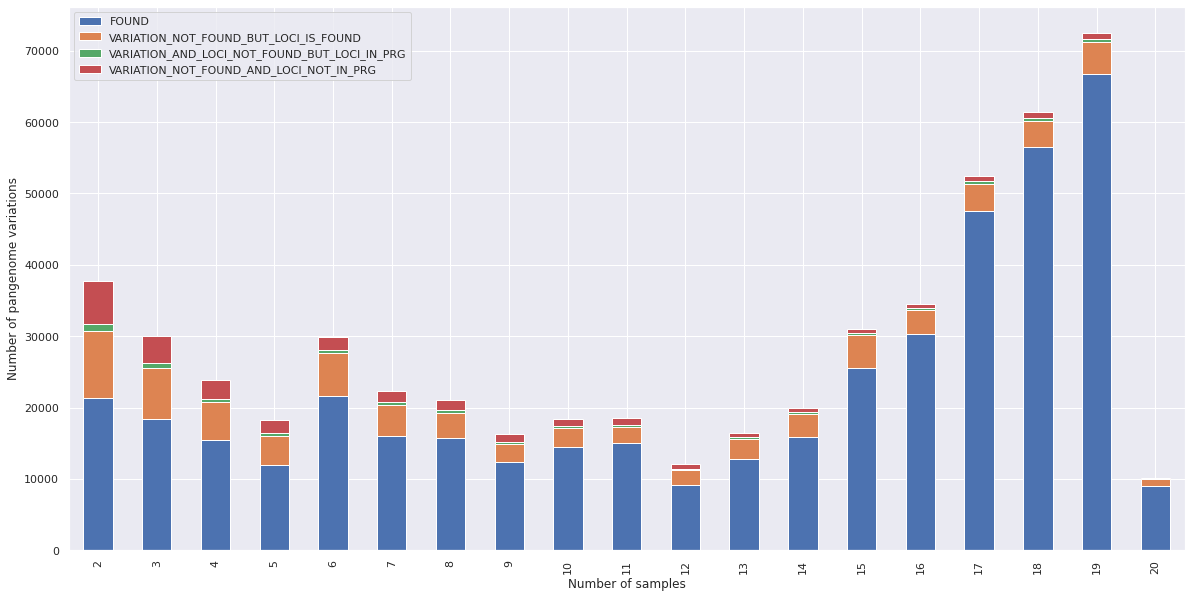

In [49]:
df = variation_found_nbofsamples[["NB_OF_SAMPLES", "FOUND", "VARIATION_NOT_FOUND_BUT_LOCI_IS_FOUND", "VARIATION_AND_LOCI_NOT_FOUND_BUT_LOCI_IN_PRG", "VARIATION_NOT_FOUND_AND_LOCI_NOT_IN_PRG"]].groupby("NB_OF_SAMPLES").sum()
sns.set(rc={'figure.figsize':(20,10)})
plot = df.plot(kind='bar', stacked=True)
plot.set(xlabel='Number of samples', ylabel='Number of pangenome variations')
fig = plot.get_figure()
fig.savefig("pandora_FN.png")